In [1]:
import networkx

#Create Graph
def generateItemGraph(graphNumber):
    itemGraph = networkx.MultiDiGraph()
    itemGraph.add_node('Item' + str(graphNumber), value = '')
    itemGraph.add_node('ItemName' + str(graphNumber), value = '')
    itemGraph.add_node('ItemAffordance' + str(graphNumber), value = '')
    itemGraph.add_node('ItemDescription' + str(graphNumber), value = '')
    itemGraph.add_node('ItemRole' + str(graphNumber), value = '')

    itemGraph.add_edge('Item' + str(graphNumber), 'ItemName' + str(graphNumber), value = 'ItemHasName')
    itemGraph.add_edge('Item' + str(graphNumber), 'ItemAffordance' + str(graphNumber), value = 'ItemHasAffordance')
    itemGraph.add_edge('Item' + str(graphNumber), 'ItemDescription' + str(graphNumber), value = 'ItemHasDescription')
    itemGraph.add_edge('Item' + str(graphNumber), 'ItemRole' + str(graphNumber), value = 'ItemHasRole')

    return itemGraph

def generatePropGraph(graphNumber):
    propGraph = networkx.MultiDiGraph()
    propGraph.add_node('Property' + str(graphNumber), value = '')
    propGraph.add_node('PropertyAdjective' + str(graphNumber), value = '')
    propGraph.add_node('PropertySecondaryObject' + str(graphNumber), value = '')
    propGraph.add_node('PropertyTertiaryObject' + str(graphNumber), value = '')
    propGraph.add_node('PropertyDegree' + str(graphNumber), value = '')
    propGraph.add_node('PropertyCompTarget' + str(graphNumber), value = '')

    propGraph.add_edge('Property' + str(graphNumber), 'PropertyAdjective' + str(graphNumber), value = 'PropertyHasAdjective')
    propGraph.add_edge('Property' + str(graphNumber), 'PropertySecondaryObject' + str(graphNumber), value = 'PropertyHasSecondaryObject')
    propGraph.add_edge('Property' + str(graphNumber), 'PropertyTertiaryObject' + str(graphNumber), value = 'PropertyHasTertiaryObject')
    propGraph.add_edge('Property' + str(graphNumber), 'PropertyDegree' + str(graphNumber), value = 'PropertyHasDegree')
    propGraph.add_edge('Property' + str(graphNumber), 'PropertyCompTarget' + str(graphNumber), value = 'PropertyHasCompTarget')

    return propGraph

def generateActionGraph(graphNumber):
    actionGraph = networkx.MultiDiGraph()
    actionGraph.add_node('Action' + str(graphNumber), value = '')
    actionGraph.add_node('ActionVerb' + str(graphNumber), value = '')
    
    actionGraph.add_edge('Action' + str(graphNumber), 'ActionVerb' + str(graphNumber), value = 'ActionHasVerb')
    
    return actionGraph

def generateModPPGraph(graphNumber):
    modPPGraph = networkx.MultiDiGraph()
    modPPGraph.add_node('ModPP' + str(graphNumber), value = '')
    modPPGraph.add_node('ModPPPrep' + str(graphNumber), value = '')
    
    modPPGraph.add_edge('ModPP' + str(graphNumber), 'ModPPPrep' + str(graphNumber), value = 'ModPPHasPrep')
    
    return modPPGraph

In [2]:
class ItemGraph(object):
    #Constructor
    def __init__(self, graphNumber):
        self.graphNumber = graphNumber
        if(graphNumber != None):
            self.graph = generateItemGraph(self.graphNumber)
        else:
            self.graph = None
        
    #Generic append method based on whatever target is passed in    
    def __append(self, target, newValue):
        currentValue = self.graph.nodes(data=True)[target + str(self.graphNumber)]['value']
        if(currentValue == ''):
            updatedValue = newValue
        else:
            updatedValue = currentValue + '|' + newValue
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = updatedValue
    
    #Generic replace method based on whatever target is passed in
    def __replace(self, target, newValue):
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = newValue

    #Append/replace methods for each node value in Item Graph
    def appendItemValue(self, newValue):
        self.__append('Item', newValue)
        
    def replaceItemValue(self, newValue):
        self.__replace('Item', newValue)
                
    def appendItemName(self, newName):
        self.__append('ItemName', newName)
        
    def replaceItemName(self, newName):
        self.__replace('ItemName', newName)
        
    def appendItemAffordance(self, newAffordance):
        self.__append('ItemAffordance', newAffordance)
    
    def replaceItemAffordance(self, newAffordance):
        self.__replace('ItemAffordance', newAffordance)
    
    def appendItemDescription(self, newDescription):
        self.__append('ItemDescription', newDescription)
    
    def replaceItemDescription(self, newDescription):
        self.__replace('ItemDescription', newDescription)
    
    def appendItemRole(self, newRole):
        self.__append('ItemRole', newRole)
    
    def replaceItemRole(self, newRole):
        self.__replace('ItemRole', newRole)
    
    #Method to get the type of graph    
    #def getTypeOfNode(self, node):
    #    print(node)
    #    print(self.graph.nodes[node])
    #    return self.graph.nodes[node]['value']
        
    #Method to find a node containing a given value
    def FindItemWithValue(self, valueToFind):
        if(self.graph != None):
            #iterate through all graph nodes
            for node, values in self.graph.nodes.data():
                #print(node, values)
                #If the current Node's value = the value passed in
                if(values['value'] == valueToFind):
                    return node
        return None
    
    #Methods to add different types of edges between nodes
    def addGroupMembershipEdges(self, groupNode, memberNode):
        self.graph.add_edge(memberNode, groupNode, value='IsMemberOf')
        self.graph.add_edge(groupNode, memberNode, value='HasMember')
        
    def addNodeEquivalencyEdges(self, firstNode, secondNode):
        self.graph.add_edge(firstNode, secondNode, value='IsEquivalentTo')
        self.graph.add_edge(secondNode, firstNode, value='IsEquivalentTo')
        
    def addCompositionEdges(self, composedNode, partOfNode):
        self.graph.add_edge(composedNode, partOfNode, value='HasA')
        self.graph.add_edge(partOfNode, composedNode, value='IsPartOf')
          
    def addPropertyEdge(self, objectNode, propertyNode):
        self.graph.add_edge(objectNode, propertyNode, value='Is')
    
   #Methods to add different types of edges between nodes
    def addActionPerformerEdges(self, performerNode, actionNode):
        self.graph.add_edge(performerNode, actionNode, value='Performs')
        self.graph.add_edge(actionNode, performerNode, value='IsPerformedBy')
        
    def addActionTargetEdges(self, actionNode, targetNode):
        self.graph.add_edge(actionNode, targetNode, value='HasTarget')
        self.graph.add_edge(targetNode, actionNode, value='IsTargetOf')
        
    def addModifierVerbEdges(self, modifierNode, verbNode):
        self.graph.add_edge(modifierNode, verbNode, value='ModifiesVerb')
        self.graph.add_edge(verbNode, modifierNode, value='isModifiedBy')
        
    def addModifierObjectEdges(self, modifierNode, objectNode):
        self.graph.add_edge(modifierNode, objectNode, value='modifiesObject')
        self.graph.add_edge(objectNode, modifierNode, value='isModifiedBy')
        
    def addConditionalTriggerEdges(self, ifNodeValue, thenNodeValue):
        ifNode = self.FindItemWithValue(ifNodeValue)
        thenNode = self.FindItemWithValue(thenNodeValue)
        #We only want to trigger actions, not statement
        if(ifNode != None and thenNode != None):
            if('Action' in thenNode):
                self.graph.add_edge(ifNode, thenNode, value='triggers')
                self.graph.add_edge(thenNode, ifNode, value='isTriggeredBy')
        
    #Methods to replace values of specific nodes
    def ReplaceItemAffordanceAtSpecificNode(self, nodeToAddAffordance, newAffordance):
        node = self.FindItemWithValue(nodeToAddAffordance)
        if(node != None):
            edgesFromNode = self.graph.edges(node, data=True)
            for startNode, endNode, edgeValues in edgesFromNode:
                #If an edge has the value ItemHasName, then we want to modify the end node
                if(edgeValues['value'] == 'ItemHasAffordance'):
                    #Update graph with name
                    self.graph.nodes(data=True)[endNode]['value'] = newAffordance
                    return True
        else:
            print("No node with direct object reference as value found")
            return False
        
    #Methods to replace values of specific nodes
    def AppendItemAffordanceAtSpecificNode(self, nodeToAddAffordance, newAffordance):
        node = self.FindItemWithValue(nodeToAddAffordance)
        if(node != None):
            edgesFromNode = self.graph.edges(node, data=True)
            for startNode, endNode, edgeValues in edgesFromNode:
                #If an edge has the value ItemHasName, then we want to modify the end node
                if(edgeValues['value'] == 'ItemHasAffordance'):
                    #Update graph with name
                    currentValue = self.graph.nodes(data=True)[endNode]['value']
                    if(currentValue == ''):
                        updatedValue = newAffordance
                    else:
                        updatedValue = currentValue + '|' + newAffordance
                    self.graph.nodes(data=True)[endNode]['value'] = updatedValue
                    return True
        else:
            print("No node with direct object reference as value found")
            return False


    #Methods to replace values of specific nodes
    def AppendValueAtSpecificNode(self, nodeToAddValue, newValue):
        #Update graph with name
        currentValue = self.graph.nodes(data=True)[nodeToAddValue]['value']
        if(currentValue == ''):
            updatedValue = newAffordance
        else:
            updatedValue = currentValue + '|' + newValue
            self.graph.nodes(data=True)[nodeToAddValue]['value'] = updatedValue
        return True
        
    def ReplaceItemNameAtSpecificNode(self, nodeToAddName, newName):
        #Find Node
        node = self.FindItemWithValue(nodeToAddName)
        if(node != None):
            #Get list of edges from the node
            edgesFromNode = self.graph.edges(node, data=True)
            for startNode, endNode, edgeValues in edgesFromNode:
                #If an edge has the value ItemHasName, then we want to modify the end node
                if(edgeValues['value'] == 'ItemHasName'):
                    #Update graph with name
                    self.graph.nodes(data=True)[endNode]['value'] = newName
                    return True
        else:
            print("No node with direct object reference as value found")
            return False

In [3]:
class PropertyGraph(object):
    #Constructor
    def __init__(self, graphNumber):
        self.graphNumber = graphNumber
        if(graphNumber != None):
            self.graph = generatePropGraph(self.graphNumber)
        else:
            self.graph = None
        
    #Generic append method based on whatever target is passed in    
    def __append(self, target, newValue):
        currentValue = self.graph.nodes(data=True)[target + str(self.graphNumber)]['value']
        if(currentValue == ''):
            updatedValue = newValue
        else:
            updatedValue = currentValue + '|' + newValue
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = updatedValue
    
    #Generic replace method based on whatever target is passed in
    def __replace(self, target, newValue):
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = newValue

    #Append/replace methods for each node value in Property Graph
    def appendPropValue(self, newValue):
        self.__append('Property', newValue)
        
    def replacePropValue(self, newValue):
        self.__replace('Property', newValue)
                
    def appendPropAdj(self, newAdjective):
        self.__append('PropertyAdjective', newAdjective)
        
    def replacePropAdj(self, newValue):
        self.__replace('PropertyAdjective', newAdjective)
        
    def appendPropSecObj(self, newSecondaryObject):
        self.__append('PropertySecondaryObject', newSecondaryObject)
        
    def replacePropSecObj(self, newSecondaryObject):
        self.__replace('PropertySecondaryObject', newSecondaryObject)
        
    def appendPropTertObj(self, newTertiaryObject):
        self.__append('PropertyTertiaryObject', newTertiaryObject)
        
    def replacePropTertObj(self, newTertiaryObject):
        self.__replace('PropertyTertiaryObject', newTertiaryObject)
        
    def appendPropDegree(self, newDegree):
        self.__append('PropertyDegree', newDegree)
        
    def replacePropDegree(self, newDegree):
        self.__replace('PropertyDegree', newDegree)
        
    def appendPropCompTarget(self, newCompTarget):
        self.__append('PropertyCompTarget', newCompTarget)
        
    def replacePropCompTarget(self, newCompTarget):
        self.__replace('PropertyCompTarget', newCompTarget)
            
    #Method to get the type of graph    
    ##def getTypeOfNode(self, node):
    #    return self.graph.nodes[node]['value']
    
    #Method to find a node containing a given value
    def FindPropertyWithValue(self, valueToFind):
        if(self.graph != None):
            #iterate through all graph nodes
            for node, values in self.graph.nodes.data():
                #If the current Node's value = the value passed in
                if(values['value'] == valueToFind):
                    return node
        return None

In [4]:
class ActionGraph(object):
    #Constructor
    def __init__(self, graphNumber):
        self.graphNumber = graphNumber
        if(graphNumber != None):
            self.graph = generateActionGraph(self.graphNumber)
        else:
            self.graph = None
        
    #Generic append method based on whatever target is passed in    
    def __append(self, target, newValue):
        currentValue = self.graph.nodes(data=True)[target + str(self.graphNumber)]['value']
        if(currentValue == ''):
            updatedValue = newValue
        else:
            updatedValue = currentValue + '|' + newValue
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = updatedValue
    
    #Generic replace method based on whatever target is passed in
    def __replace(self, target, newValue):
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = newValue

    #Append/replace methods for each node value in Property Graph
    def appendActionValue(self, newValue):
        self.__append('Action', newValue)
        
    def replaceActionValue(self, newValue):
        self.__replace('Action', newValue)
                
    def appendActionVerb(self, newVerb):
        self.__append('ActionVerb', newVerb)
        
    def replaceActionVerb(self, newValue):
        self.__replace('ActionVerb', newVerb)
        
    #Method to get the type of graph    
    ##def getTypeOfNode(self, node):
    #    return self.graph.nodes[node]['value']
    
    #Method to find a node containing a given value
    def FindActionWithValue(self, valueToFind):
        if(self.graph != None):
            #iterate through all graph nodes
            for node, values in self.graph.nodes.data():
                #If the current Node's value = the value passed in
                if(values['value'] == valueToFind):
                    return node
        return None

In [5]:
#Modifier_PP (adv will need a different graph)
class ModifierPPGraph(object):
    #Constructor
    def __init__(self, graphNumber):
        self.graphNumber = graphNumber
        if(graphNumber != None):
            self.graph = generateModPPGraph(self.graphNumber)
        else:
            self.graph = None
        
    #Generic append method based on whatever target is passed in    
    def __append(self, target, newValue):
        currentValue = self.graph.nodes(data=True)[target + str(self.graphNumber)]['value']
        if(currentValue == ''):
            updatedValue = newValue
        else:
            updatedValue = currentValue + '|' + newValue
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = updatedValue
    
    #Generic replace method based on whatever target is passed in
    def __replace(self, target, newValue):
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = newValue

    #Append/replace methods for each node value in Property Graph
    def appendModPPValue(self, newValue):
        self.__append('ModPP', newValue)
        
    def replaceModPPValue(self, newValue):
        self.__replace('ModPP', newValue)
                
    def appendModPPPrep(self, newPreposition):
        self.__append('ModPPPrep', newPreposition)
        
    def replaceModPPPrep(self, newPreposition):
        self.__replace('ModPPPrep', newPreposition)
    
    #Method to get the type of graph    
    ##def getTypeOfNode(self, node):
    #    return self.graph.nodes[node]['value']
    
    #Method to find a node containing a given value
    def FindModWithValue(self, valueToFind):
        if(self.graph != None):
            #iterate through all graph nodes
            for node, values in self.graph.nodes.data():
                #If the current Node's value = the value passed in
                if(values['value'] == valueToFind):
                    return node
        return None

In [6]:
class predicateSwitcher(object):
    
    def __init__(self):
        self.graphNumber = 0
        self.DRSGraph = ItemGraph(None)
        
    #Method to call the appropriate function based on the argument passed in
    def callFunction(self, predicateType, predicateContents):
        #Get the name of the method
        methodName = 'predicate_' + str(predicateType)
        #Get the method itself
        method = getattr(self, methodName, lambda: "Unknown predicate")
        #Call the method and return its output
        method(predicateContents)
        return self.DRSGraph
        
    def updateDRSGraph(self, newDRSGraph):
        self.DRSGraph = newDRSGraph
        
    #For object() predicates
    #SHOULD CHECK IF OBJECT WITH GIVEN NAME ALREADY EXISTS!!!  IF SO, FIGURE OUT WHAT ARE THE CONDITIONS FOR THAT TO OCCUR
    def predicate_object(self, predicateContents):
        #print(predicateContents)
        #Break up elements of object line into variables
        predicateComponents = predicateContents.split(',')
        objReferenceVariable = predicateComponents[0]
        objName = predicateComponents[1]
        objClass = predicateComponents[2]
        objUnit = predicateComponents[3]
        objOperator = predicateComponents[4]
        objCount = predicateComponents[5].split(')')[0]
        if(self.DRSGraph.FindItemWithValue(objReferenceVariable) == None):
            #Apply appropriate variables to ItemGraph
            objectGraph = ItemGraph(self.graphNumber)
            objectGraph.appendItemValue(objReferenceVariable)
            objectGraph.appendItemRole(objName)
            #Increase the graph number for auto-generation of names
            self.graphNumber = self.graphNumber + 1
            #If a main graph already exists, then add the new graph in to it
            if(self.DRSGraph.graph != None):
                #DRSGraph.graph = networkx.algorithms.operators.binary.union(DRSGraph.graph, objectGraph.graph)
                self.DRSGraph.graph = networkx.algorithms.operators.binary.compose(self.DRSGraph.graph, objectGraph.graph)
            #if no main graph exists, this is the main graph
            else:
                self.DRSGraph.graph = objectGraph.graph
            return True
        else:
            return False
    
    #For predicate() predicates
    #HOW TO HANDLE SENTENCE SUB-ORDINATION?
    def predicate_predicate(self, predicateContents):
        #Intransitive verbs: (predName, verb, subjectRef) 
        #- The SubjectRef Verbed (the man laughed, the target appears)
        #Transitive verbs: (predName, verb, subjectRef, dirObjRef)
        #- The Subjectref Verbed the dirObjRef (the task A has a group of objects H, the subject L remembers the letter I)
        #Ditransitive verbs: (predName, verb, subjRef, dirObjRef, indirObjRef)
        #- The SubjectRef verbed the DirObjRef to the indirObjRef (The professor (S) gave the paper (D) to the student (I))
        #Break up the predicate
        predicateComponents = predicateContents.split(',')
        numberOfComponents = len(predicateComponents)
        #Always have first three components, so only special cases are transitive/ditransitive
        predReferenceVariable = predicateComponents[0]
        predVerb = predicateComponents[1]
        predSubjRef = predicateComponents[2]
        #Different cases (differing number of components)
        if(numberOfComponents == 3):
            #intransitive
            predSubjRef = predSubjRef.split(')')[0]
        elif(numberOfComponents == 4):
            #Transitive
            predDirObjRef = predicateComponents[3].split(')')[0]
        elif(numberOfComponents == 5):
            #Ditransitive
            predIndirObjRef = predicateComponents[4].split(')')[0]
        else:
            #invalid
            raise ValueError('Too many components ?')
        #Hardcode be case for specific scenarios
        
        if(predVerb == 'be'):
            #Check if naming or setting an equivalency
            if('named' in predSubjRef):
                #If so call naming method
                self.DRSGraph = nameItem(predSubjRef, predDirObjRef, self.DRSGraph)
            #If not named(XYZ) but still has 4 components
            elif(numberOfComponents == 4):
                #Get nodes for both subject and direct object
                subjRefNode = self.DRSGraph.FindItemWithValue(predSubjRef)
                dirObjRefNode = self.DRSGraph.FindItemWithValue(predDirObjRef)
                #If both are ITEM nodes in the graph, then the "Be" is setting an equivalency
                if(subjRefNode != None and dirObjRefNode != None and 'Item' in dirObjRefNode):
                    self.DRSGraph.addNodeEquivalencyEdges(subjRefNode, dirObjRefNode)
                #If the target node is a PROPERTY node, then the 'BE' is setting an "is" property relationship
                elif(subjRefNode != None and dirObjRefNode != None and 'Property' in dirObjRefNode):
                    self.DRSGraph.addPropertyEdge(subjRefNode, dirObjRefNode)
            #HANDLE ANY OTHER CASES????
            
        #Hardcode "have" case for composition
        elif(predVerb == 'have'):
            if(numberOfComponents == 4):
                #Get nodes for both subject and direct object
                subjRefNode = self.DRSGraph.FindItemWithValue(predSubjRef)
                dirObjRefNode = self.DRSGraph.FindItemWithValue(predDirObjRef)
                #If both are nodes in the graph, then the "have" is setting a composition
                if(subjRefNode != None and dirObjRefNode != None):
                    self.DRSGraph.addCompositionEdges(subjRefNode, dirObjRefNode)
        else:
            #Create Action Node
            self.DRSGraph.AppendItemAffordanceAtSpecificNode(predSubjRef, predVerb)
            actionGraph = ActionGraph(self.graphNumber)
            actionGraph.appendActionValue(predReferenceVariable)
            actionGraph.appendActionVerb(predVerb)
            #Increase the graph number for auto-generation of names
            self.graphNumber = self.graphNumber + 1
            #If a main graph already exists, then add the new graph in to it
            if(self.DRSGraph.graph != None):
                self.DRSGraph.graph = networkx.algorithms.operators.binary.compose(self.DRSGraph.graph, actionGraph.graph)
            #if no main graph exists, this is the main graph
            else:
                self.DRSGraph.graph = actionGraph.graph
            
            #Get subject reference node
            subjRefNode = self.DRSGraph.FindItemWithValue(predSubjRef)
            actionNode = self.DRSGraph.FindItemWithValue(predReferenceVariable)
            
            #If just one subject "The target appears"
            if(numberOfComponents == 3):
                #self.DRSGraph.AppendItemAffordanceAtSpecificNode(predSubjRef, predVerb)
                self.DRSGraph.addActionPerformerEdges(subjRefNode, actionNode)
            #If subject and direct object (e.g. "The subject remembers the letter")
            #predSubjRef = "Subject", predDirObjRef = "letter"
            elif(numberOfComponents == 4):
                dirObjRefNode = self.DRSGraph.FindItemWithValue(predDirObjRef)
                self.DRSGraph.addActionPerformerEdges(subjRefNode, actionNode)
                self.DRSGraph.addActionTargetEdges(actionNode, dirObjRefNode)
                
            #TODO TODO TODO TODO
            elif(numberOfComponents == 5):
                pass
    
    #For has_part() predicates
    def predicate_has_part(self, predicateContents):
        #Get predicate items
        predicateComponents = predicateContents.split(',')
        predGroupRef = predicateComponents[0]
        predGroupMember = predicateComponents[1].split(')')[0]
        #Hardcode the new object as being a group
        predGroupDescription = 'GROUP'
        #if Group reference doesn't exist
        groupNode = self.DRSGraph.FindItemWithValue(predGroupRef)
        memberNode = self.DRSGraph.FindItemWithValue(predGroupMember)
        if(groupNode == None):
             #Then create that item
             #Apply appropriate variables to ItemGraph
            groupGraph = ItemGraph(self.graphNumber)
            groupGraph.appendItemValue(predGroupRef)
            groupGraph.appendItemRole(predGroupDescription)
            #Get the node for the group
            groupNode = groupGraph.FindItemWithValue(predGroupRef)
            #Increase the graph number for auto-name generation
            self.graphNumber = self.graphNumber + 1
            #Compose the new graph with the existing graph 
            #(no scenario of no existing graph because can't start with has_part())
            self.DRSGraph.graph = networkx.algorithms.operators.binary.compose(self.DRSGraph.graph, groupGraph.graph)
        #Add membership edges
        self.DRSGraph.addGroupMembershipEdges(groupNode, memberNode)
    
    #HANDLE MODIFIERS - PREPOSITION
    #TODO TODO TODO TODO
    def predicate_modifier_pp(self, predicateContents):
        #Find action node of predicate
        #Get predicate items
        predicateComponents = predicateContents.split(',')
        modPPRefID = predicateComponents[0] + 'mod'
        modPPPrep = predicateComponents[1]
        modPPModifiedVerb = predicateComponents[0]
        modPPTargetObj = predicateComponents[2].split(')')[0]
        
        #Create Modifier Node
        modGraph = ModifierPPGraph(self.graphNumber)
        modGraph.appendModPPValue(modPPRefID)
        modGraph.appendModPPPrep(modPPPrep)
        
        #Increase the graph number for auto-generation of names
        self.graphNumber = self.graphNumber + 1
        
        #If a main graph already exists, then add the new graph in to it
        if(self.DRSGraph.graph != None):
            self.DRSGraph.graph = networkx.algorithms.operators.binary.compose(self.DRSGraph.graph, modGraph.graph)
        #if no main graph exists, this is the main graph
        else:
            self.DRSGraph.graph = modGraph.graph
            
        #Add verb and object modifier edges
        modNode = self.DRSGraph.FindItemWithValue(modPPRefID)
        verbNode = self.DRSGraph.FindItemWithValue(modPPModifiedVerb)
        objectNode = self.DRSGraph.FindItemWithValue(modPPTargetObj)
        self.DRSGraph.addModifierVerbEdges(modNode, verbNode)
        self.DRSGraph.addModifierObjectEdges(modNode, objectNode)
            
    #HANDLE MODIFIERS - ADVERB
    def predicate_modifier_adv(self, predicateContents):
        pass
    
    #HANDLE PROPERTIES
    #TODO: Handle 4/6 component properties
    #TODO: Handle degrees besides "pos"
    def predicate_property(self, predicateContents):
        #Break up the predicate
        predicateComponents = predicateContents.split(',')
        numberOfComponents = len(predicateComponents)
        #Always have first two components, others distributed based on number of components
        propRefId = predicateComponents[0]
        propAdjective = predicateComponents[1]
        #Different cases (differing number of components)
        if(numberOfComponents == 3):
            #Only a primary object
            propDegree = predicateComponents[2].split(')')[0]
        elif(numberOfComponents == 4):
            #Primary and secondary object
            propDegree = predicateComponents[2]
            propSecObj = predicateComponents[3].split(')')[0]
        elif(numberOfComponents == 6):
            #Primary, secondary, and tertiary objects
            propSecObj = predicateComponents[2]
            propDegree = predicateComponents[3]
            propCompTarget = predicateComponents[4]
            propTertObj = predicateComponents[5].split(')')[0]
        else:
            #invalid
            raise ValueError('Too many components ?')
            
        if(self.DRSGraph.FindItemWithValue(propRefId) == None):
            #Apply appropriate variables to PropertyGraph (operating off same graph number
            #because the number in the name is irrelevant)
            propGraph = PropertyGraph(self.graphNumber)
            propGraph.appendPropValue(propRefId)
            propGraph.appendPropAdj(propAdjective)
            propGraph.appendPropDegree(propDegree)
            #Increase the graph number for auto-generation of names
            self.graphNumber = self.graphNumber + 1
            #If a main graph already exists, then add the new graph in to it
            if(self.DRSGraph.graph != None):
                self.DRSGraph.graph = networkx.algorithms.operators.binary.compose(self.DRSGraph.graph, propGraph.graph)
            #if no main graph exists, this is the main graph
            else:
                self.DRSGraph.graph = propGraph.graph
            return True
        else:
            return False

In [41]:
#VERY INITIAL VERSION, MOST CODE COPIED FROM PREDICATESWITCHER
#Proof of concept class to test with single case: "Is Psychomotor-Vigilance active?"
#CURRENTLY OPERATING UNDER ASSUMPTION THAT questions ALWAYS end with the predicate as the final piece.  This will 100% need revised (probably just check if 
#the current line is the final question line and then process the complete question at that point).
class questionSwitcher(object):
    
    def __init__(self):
        self.graphNumber = 0
        self.DRSGraph = None
        self.nodesWithGivenProperty = []
        self.nodesWithGivenPropertyAntonym = []
        self.nodesWithGivenReferenceVariable = []
        self.nodesWithGivenName = []
        
    #Method to call the appropriate function based on the argument passed in
    def callFunction(self, predicateType, predicateContents, DRSGraph):
        #Get the name of the method
        methodName = 'question_' + str(predicateType)
        #Get the method itself
        method = getattr(self, methodName, lambda: "Unknown predicate")
        #Call the method and return its output
        self.DRSGraph = DRSGraph
        method(predicateContents)
        
    def returnDRSGraph(self):
        return self.DRSGraph
        
    #HANDLE PROPERTIES
    #TODO: Handle 4/6 component properties
    #TODO: Handle degrees besides "pos"
    def question_property(self, predicateContents):
        #Break up the predicate
        predicateComponents = predicateContents.split(',')
        numberOfComponents = len(predicateComponents)
        #Always have first two components, others distributed based on number of components
        propRefId = predicateComponents[0]
        propAdjective = predicateComponents[1]
        #Different cases (differing number of components)
        if(numberOfComponents == 3):
            #Only a primary object
            propDegree = predicateComponents[2].split(')')[0]
        elif(numberOfComponents == 4):
            #Primary and secondary object
            propDegree = predicateComponents[2]
            propSecObj = predicateComponents[3].split(')')[0]
        elif(numberOfComponents == 6):
            #Primary, secondary, and tertiary objects
            propSecObj = predicateComponents[2]
            propDegree = predicateComponents[3]
            propCompTarget = predicateComponents[4]
            propTertObj = predicateComponents[5].split(')')[0]
        else:
            #invalid
            raise ValueError('Too many components ?')
        
        #INITIAL NYM TESTING - will need to extend to other predicates as well of course
        adjectiveNymList, antonymList = getNyms(propAdjective)
        print("ADJECTIVES", adjectiveNymList)
        adjectiveNodes = self.ListOfNodesWithValueFromList(adjectiveNymList)
        antonymNodes = self.ListOfNodesWithValueFromList(antonymList)

        print("NODES NODES NODES", adjectiveNodes)
        newNymCount = 0
        while len(adjectiveNodes) < 1 and len(antonymNodes) < 1 and newNymCount < 3:
            #No nodes "active"
            newAdjective = requestNewTermToNymCheck(propAdjective)
            newNymCount = newNymCount + 1
            adjectiveNymList, newAntonymList = getNyms(newAdjective)
            #antonymList.extend(newAntonymList)
            antonymNodes = self.ListOfNodesWithValueFromList(antonymList)
            adjectiveNodes = self.ListOfNodesWithValueFromList(adjectiveNymList)
            # Add new term into adjective node in order to grow our vocabulary
            #for node in adjectiveNodes:
            #    print("FOUND ONE" + node)
            #    #Add original term
            #    if(propAdjective not in self.DRSGraph.graph.node[node]['value']):
            #        self.DRSGraph.AppendValueAtSpecificNode(node, propAdjective)
            #    #Add new term if it was a synonym and not a term already found
            #    if(newAdjective not in self.DRSGraph.graph.node[node]['value']):
            #        self.DRSGraph.AppendValueAtSpecificNode(node, newAdjective)
        
        if (len(adjectiveNodes) > 0):
            propertyNodesWithAdjective = []
            for node in adjectiveNodes:
                print("AdjectiveNode", node)
                 # Add new term into adjective node in order to grow our vocabulary
                if(propAdjective not in self.DRSGraph.graph.node[node]['value']):
                    self.DRSGraph.AppendValueAtSpecificNode(node, propAdjective)
                propertyNode = self.getPropertyNodeFromAdjective(node)
                #print("propertyNode", propertyNode)
                self.nodesWithGivenProperty.append(propertyNode)
            
        if (len(antonymNodes) > 0):
                propertyNodesWithAdjective = []
                for node in antonymNodes:
                    print("AntonymNode", node)
                    if(propAdjective not in self.DRSGraph.graph.node[node]['value']):
                        self.DRSGraph.AppendValueAtSpecificNode(node, propAdjective)
                    propertyNode = self.getPropertyNodeFromAdjective(node)
                    #print("propertyNode", propertyNode)
                    self.nodesWithGivenPropertyAntonym.append(propertyNode)
        #***********************************************************************************************************************************
        # If no adjective nodes are found, then we look for antonyms
        #Because of this, we are positive-biased, as if we find adjective nodes, we don't look for antonyms
        #May be a better approach to look for both and, if both are found, declare a conflict rather than assume one way or the other?
        #Slower processing time though
        #***********************************************************************************************************************************
        #else:
            #antonymNodes = self.ListOfNodesWithValueFromList(antonymList)
            # We don't want to grow the vocabulary here directly, so we skip the adding new terms
            #if (len(antonymNodes) > 0):
            #    propertyNodesWithAdjective = []
            #    for node in antonymNodes:
            #        print("AntonymNode", node)
            #        if(propAdjective not in self.DRSGraph.graph.node[node]['value']):
            #            self.DRSGraph.AppendValueAtSpecificNode(node, propAdjective)
            #        propertyNode = self.getPropertyNodeFromAdjective(node)
            #        #print("propertyNode", propertyNode)
            #        self.nodesWithGivenPropertyAntonym.append(propertyNode)

        
    #For predicate() predicates
    #HOW TO HANDLE SENTENCE SUB-ORDINATION?
    def question_predicate(self, predicateContents):
        #Intransitive verbs: (predName, verb, subjectRef) 
        #- The SubjectRef Verbed (the man laughed, the target appears)
        #Transitive verbs: (predName, verb, subjectRef, dirObjRef)
        #- The Subjectref Verbed the dirObjRef (the task A has a group of objects H, the subject L remembers the letter I)
        #Ditransitive verbs: (predName, verb, subjRef, dirObjRef, indirObjRef)
        #- The SubjectRef verbed the DirObjRef to the indirObjRef (The professor (S) gave the paper (D) to the student (I))
        #Break up the predicate
        predicateComponents = predicateContents.split(',')
        numberOfComponents = len(predicateComponents)
        #Always have first three components, so only special cases are transitive/ditransitive
        predReferenceVariable = predicateComponents[0]
        predVerb = predicateComponents[1]
        predSubjRef = predicateComponents[2]
        #Different cases (differing number of components)
        if(numberOfComponents == 3):
            #intransitive
            predSubjRef = predSubjRef.split(')')[0]
        elif(numberOfComponents == 4):
            #Transitive
            predDirObjRef = predicateComponents[3].split(')')[0]
        elif(numberOfComponents == 5):
            #Ditransitive
            predIndirObjRef = predicateComponents[4].split(')')[0]
        else:
            #invalid
            raise ValueError('Too many components ?')
        #Hardcode be case for specific scenarios
        
        if(predVerb == 'be'):
            # If the subject reference is a proper name
            #Check if we find a node containing said name
            if('named' in predSubjRef):
                #Get item name out of "named(XYZ)"
                #itemNodeList = []
                itemName = predSubjRef[predSubjRef.find("(")+1:predSubjRef.find(")")]
                #print(itemName)
                self.nodesWithGivenName = self.ListOfNodesWithValue(itemName)
                #print(self.nodesWithGivenName)
                #get list of item nodes which are connected to each of these names.
                #print(nameNodeList)
                #for node in nameNodeList:
                #    itemNode = self.getItemNodeFromName(node)
                #    self.nodesWithGivenName.append(itemNode)
            # If the subject reference is another variable, not a proper name
            else:
                itemRefVar = predSubjRef
                self.nodesWithGivenReferenceVariable = self.ListOfNodesWithValue(itemRefVar)
                print("REFVARNODES", self.nodesWithGivenReferenceVariable, "********************")
            
    def resolveQuestion(self):
        for node in self.nodesWithGivenName:
            outEdgesFromNode = (self.DRSGraph.graph.out_edges(node, data=True))
            inEdgesFromNode = (self.DRSGraph.graph.in_edges(node, data=True))
            edgesFromNode = list(outEdgesFromNode) + list(inEdgesFromNode)
            #print(edgesFromNode)
            for startNode, endNode, edgeValues in edgesFromNode:
                print(startNode, endNode, edgeValues)
                if(edgeValues['value'] == 'ItemHasName'):
                    if(startNode != node):
                        nodeToConnect = startNode
                        #print(nodeToConnect)
                    elif(endNode != node):
                        nodeToConnect = endNode
                        #print(nodeToConnect)
        for node in self.nodesWithGivenReferenceVariable:
            nodeToConnect = node
            
        for node in self.nodesWithGivenProperty:
            #print(node)
            if(self.DRSGraph.graph.has_edge(node, nodeToConnect)):
                return True
            if(self.DRSGraph.graph.has_edge(nodeToConnect, node)):
                return True
        for antonymNode in self.nodesWithGivenPropertyAntonym:
            #print(node)
            if(self.DRSGraph.graph.has_edge(antonymNode, nodeToConnect)):
                return False
            if(self.DRSGraph.graph.has_edge(nodeToConnect, antonymNode)):
                return False    
        return None
    
    def ListOfNodesWithValueFromList(self, listOfNyms):
        nodeList = []
        for valueToFind in listOfNyms:
            print(valueToFind)
            if(self.DRSGraph != None):
                #iterate through all graph nodes
                for node, values in self.DRSGraph.graph.nodes.data():
                    #If the current Node's value = the value passed in
                    # Changed from valueToFind in values to valueToFind == values as "active" was triggering found in "inactive" due to being substr

                    if(valueToFind == values['value']):
                        print("FOUND", valueToFind)
                        nodeList.append(node)
        print(nodeList)
        return nodeList
    
    def ListOfNodesWithValue(self, valueToFind):
        nodeList = []
        if(self.DRSGraph != None):
            #iterate through all graph nodes
            for node, values in self.DRSGraph.graph.nodes.data():
                #If the current Node's value = the value passed in
                # Changed from valueToFind in values to valueToFind == values as "active" was triggering found in "inactive" due to being substr
                if(valueToFind == values['value']):
                    nodeList.append(node)
        return nodeList    
    
    def getPropertyNodeFromAdjective(self, adjectiveNode):
        #Get list of edges from the node
        inEdgesFromNode = self.DRSGraph.graph.in_edges(adjectiveNode, data=True)
        outEdgesFromNode = self.DRSGraph.graph.out_edges(adjectiveNode, data=True)
        edgesFromNode = list(inEdgesFromNode) + list(outEdgesFromNode)
        for startNode, endNode, edgeValues in edgesFromNode:
            #If an edge has the value ItemHasName, then we want to modify the end node
            if(edgeValues['value'] == 'PropertyHasAdjective'):
                #Update graph with name
                return startNode
            
    def getItemNodeFromName(self, nameNode):
        #Get list of edges from the node
        edgesFromNode = self.DRSGraph.graph.edges(nameNode, data=True)
        for startNode, endNode, edgeValues in edgesFromNode:
            #If an edge has the value ItemHasName, then we want to modify the end node
            if(edgeValues['value'] == 'ItemHasName'):
                #Update graph with name
                #print(startNode, endNode, edgeValues)
                return startNode

In [25]:
def requestNewTermToNymCheck(originalTerm):
    newTerm = input("Sorry, I don't understand \"" + originalTerm + "\".  Please give me an alternate word and I'll make the connection.")
    return newTerm

In [9]:
#CAN PROBABLY MAKE THE NAME CHANGE A CLASS FUNCTION ????  MAKE APPEND/REPLACE BE ABLE TO TAKE IN SPECIFIC TARGETS?
def nameItem(predSubjRef, predDirObjRef, DRSGraph):
    #Get item name out of "named(XYZ)"
    itemName = predSubjRef[predSubjRef.find("(")+1:predSubjRef.find(")")]
    #Replace the name
    DRSGraph.ReplaceItemNameAtSpecificNode(predDirObjRef, itemName)
    #Return graph
    return DRSGraph

In [10]:
#Check if current line is a conditional or a header line
def getSymbolLines(DRSLines):
    #Declarations
    symbolLines = {}
    #Iterate through DRS commands
    for index, line in enumerate(DRSLines):
        #If line starts with bracket, it's a header
        if(line[0] == '['):
            symbolLines.update({index: "header"})
        #if line is arrow, it's a conditional
        elif(line == '=>'):
            symbolLines.update({index: "conditional"})
        #if line is "QUESTION" then it's the start of a question segement
        elif(line == 'QUESTION'):
            symbolLines.update({index: "question-tag"})
    print(symbolLines)
    return symbolLines

In [11]:
def categorizeSymbolLines(symbolLines):
    
    #SymbolLines - check surrounding symbols and set instruction-header/if-header/then-header/question-header accordingly
    symbolLineIndexes = list(symbolLines.keys())
    categorizedSymbolLines = {}
    for symbolIndex, symbolLineNumber in enumerate(symbolLineIndexes):
        #Get symbol and surrounding symbols
        currentSymbol = symbolLines[symbolLineNumber]
        previousSymbol = None
        nextSymbol = None
        #If not first line, then set previous symbol
        if(symbolIndex != 0):
            previousSymbolLineNumber = symbolLineIndexes[symbolIndex - 1]
            previousSymbol = symbolLines[previousSymbolLineNumber]
        #If not last line, then set next symbol
        if(symbolIndex < (len(symbolLines) - 1)):
            nextSymbolLineNumber = symbolLineIndexes[symbolIndex + 1]
            nextSymbol = symbolLines[nextSymbolLineNumber]
        #Categorize headers (ignore rest)
        if(currentSymbol == 'header'):
            #First header always = instruction as far as I've been able to see
            if(previousSymbol == None):
                categorizedSymbolLines.update({symbolLineNumber: 'instruction-header'})
            #If previous symbol is "QUESTION", then header is for a question
            if(previousSymbol == 'question-tag'):
                categorizedSymbolLines.update({symbolLineNumber: 'question-header'})
            #if previous symbol is a conditional, then header is for a then part of the conditional
            if(previousSymbol == 'conditional'):
                categorizedSymbolLines.update({symbolLineNumber: 'then-header'})
            #if next symbol is a conditional, then header is for an if part of the conditional
            if(nextSymbol == 'conditional'):
                categorizedSymbolLines.update({symbolLineNumber: 'if-header'})
        else:
            categorizedSymbolLines.update({symbolLineNumber: currentSymbol})
    return categorizedSymbolLines

In [12]:
#Categorize each variable in the DRS program with a type (instruction, if, then, question)
def categorizeVariables(DRSLines, catgorizedSymbolLines):
    variablesAndTypes = {}
    #Iterate through Symbol Lines in order to extract each variable from the headers and its associated type
    for symbolLineNumber, symbolLineType in catgorizedSymbolLines.items():
        #check if headedr type
        if('header' in symbolLineType):
            #get current line
            currentSymbolLine = DRSLines[symbolLineNumber]
            #strip brackets
            currentSymbolLine = currentSymbolLine.replace('[', '')
            currentSymbolLine = currentSymbolLine.replace(']', '')
            #Get list of variables contained in header
            currentTargetVariables = currentSymbolLine.split(',')
            #Get current type of the header by stripping the header part of the tag and leaving the type
            currentHeaderType = symbolLineType.split('-header')[0]
            #Assign each variable in the curent line to have the associated type with the header
            for variable in currentTargetVariables:
                variablesAndTypes.update({variable: currentHeaderType})
    return variablesAndTypes

In [13]:
#Assign a type (instruction, if, then, question) to each line of the DRS instructions in order to easily check line-type during processing
def categorizeDRSLines(DRSLines, symbolLines):
    categorizedDRSLines = {}
    #get categorization of each symbol line
    categorizedSymbolLines = categorizeSymbolLines(symbolLines)
    #Get categorizations of each variable
    variablesAndTypes = categorizeVariables(DRSLines, categorizedSymbolLines)
    #Iterate through DRSLines
    for index, line in enumerate(DRSLines):
        #If current line is in one of the symbol lines, give it the exact same type as it already has
        if(index in categorizedSymbolLines.keys()):
            currentLineType = categorizedSymbolLines.get(index)
            categorizedDRSLines.update({index: currentLineType})
        #otherwise, it's an instruction - check its reference variable and assign the associated type to the line
        else:
            #Get the contents of this given instruction
            predicateContents = line.split('(', 1)[1]
            #Get the reference variable of the instruction
            preciateReferenceVariable = predicateContents.split(',', 1)[0]
            #Get the type asssociated with this variable
            currentInstructionType = variablesAndTypes.get(preciateReferenceVariable)
            categorizedDRSLines.update({index: currentInstructionType})
    return categorizedDRSLines

In [14]:
from nltk.corpus import wordnet

def getNyms(wordToCheck):
    #Iterate through all words to check
    synonyms = []
    hypernyms = []
    hyponyms = []
    deriv = []
    uniqueNymList = []
    uniqueAntonymList = []
    #for currentWord in checkWordList:
    synonyms.clear()
    hypernyms.clear()
    hyponyms.clear()
    deriv.clear()
    print(wordToCheck)
    #print(currentWord)
    #print(checkWordList[currentWord])
    #Get synsets of current word to check
    testWord = wordnet.synsets(wordToCheck)
    #for each synset (meaning)
    for syn in testWord:
        #Get Hypernyms
        if(len(syn.hypernyms()) > 0):
            currentHypernyms = syn.hypernyms()
            for hyperSyn in currentHypernyms:
                for lemma in hyperSyn.lemmas():
                    #if(lemma.name() != currentWord):
                    hypernyms.append(lemma.name())
                #hypernyms.append(hyperSyn.lemma_names())
        #Get Hyponyms
        if(len(syn.hyponyms()) > 0):
            currentHyponyms = syn.hyponyms()
            for hypoSyn in currentHyponyms:
                for lemma in hypoSyn.lemmas():
                    #if(lemma.name() != currentWord):
                    hyponyms.append(lemma.name())
                #hypernyms.append(hyperSyn.lemma_names())
        #Get direct synonyms
        for lemma in syn.lemmas():
            #if(lemma.name() != currentWord):
            synonyms.append(lemma.name())
            #Get derivationally related forms
            for derivForm in lemma.derivationally_related_forms():
                if(derivForm.name() not in deriv):
                    deriv.append(derivForm.name())
            #Get antonyms
            if lemma.antonyms():
                #print(lemma.antonyms()[0].name())
                if(lemma.antonyms()[0].name() not in uniqueAntonymList):
                    uniqueAntonymList.append(lemma.antonyms()[0].name())
    #print("SYNONYMS: ")
    #print(set(synonyms))
    #print('\n HYPERNYMS:')
    #print(set(hypernyms))
    #print('\n HYPONYMS:')
    #print(set(hyponyms))
    #print('\n DERIVATIONALLY RELATED FORMS:')
    #print(set(deriv))
    nymLists = synonyms + hypernyms + hyponyms + deriv
    uniqueNyms = set(nymLists)
    uniqueNymList = list(uniqueNyms)
    print(uniqueNymList)
    print("ANTONYMS", uniqueAntonymList)
    return uniqueNymList, uniqueAntonymList

In [15]:
class Conditional():
    def __init__(self, firstLine):
        self.firstLine = firstLine
        self.anonFirstLine = ''
        self.ifLines = []
        self.anonIfLines = []
        self.thenLines = []
        self.anonThenLines = []
        self.processed = False
        
    def addIfLine(self, newIfLine):
        self.ifLines.append(newIfLine)
        
    def addThenLine(self, newThenLine):
        self.thenLines.append(newThenLine)

    def addAnonIfLine(self, newAnonIfLine):
        self.anonIfLines.append(newAnonIfLine)
        
    def addAnonThenLine(self, newAnonThenLine):
        self.anonThenLines.append(newAnonThenLine)
        
    def replaceIfLines(self, newIfLines):
        self.ifLines = newIfLines
        
    def replaceAnonIfLines(self, newAnonIfLines):
        self.anonIfLines = newAnonIfLines
        
    def replaceFirstLine(self, newFirstLine):
        self.firstLine = newFirstLine
        
    def replaceAnonFirstLine(self, newAnonFirstLine):
        self.anonFirstLine = newAnonFirstLine
        
    def markProcessed(self):
        self.processed = True
        
    def pprint(self):
        print("firstLine: " + self.firstLine)
        print("anonfirstLine: " + self.anonFirstLine)
        print("IF: ")
        print(self.ifLines)
        print("THEN: ")
        print(self.thenLines)
        print("ANON IF: ")
        print(self.anonIfLines)
        print("ANON THEN: ")
        print(self.anonThenLines)
        print("PROCESSED: ")
        print(self.processed)

In [16]:
import re
#Iterate through all reference variable/replacement number pairs and perform the substitution, then return the anonymized if line
def replaceReferenceVariables(ifLine, referenceVariables):
    for originalVariable, replacementNumber in referenceVariables.items():
        ifLine = re.sub(originalVariable, str(replacementNumber), ifLine)
    return ifLine

In [17]:
#Make the preidcate reference variables irrelevant so that checking if an incoming instruction is equivalent to a conditional if is easier
def anonymizeIfs(conditionalToAnonymize):
    #Get list of reference variables and assign a number to each to track order, then replace the variable with the number
    referenceVariables = {}
    currentVarNumber = 0
    anonymizedIfLines = []
    #assign a number to each if line's reference var in each conditional
    for ifLine in conditionalToAnonymize.ifLines:
        predicateContents = ifLine.split('(', 1)[1]
        predicateReferenceVariable = predicateContents.split(',', 1)[0]
        #Make sure not to overwrite something already found (for instance, modifiers have the same ref var)
        if(predicateReferenceVariable not in referenceVariables.keys()):
            referenceVariables.update({predicateReferenceVariable: currentVarNumber})
        currentVarNumber = currentVarNumber + 1
    #Now iterate through ifline's and replace each instance of a reference var with the associated number
    for ifLine in conditionalToAnonymize.ifLines:
        anonIfLine = replaceReferenceVariables(ifLine, referenceVariables)
        anonymizedIfLines.append(anonIfLine)
    conditionalToAnonymize.replaceAnonIfLines(anonymizedIfLines)
    conditionalToAnonymize.replaceAnonFirstLine(anonymizedIfLines[0])
    return conditionalToAnonymize

In [18]:
def getConditionals(DRSLines, categorizedDRSLines):
        #Need to make groups of which parts are related
        conditionalLines = {}
        for currentLineNumber in categorizedDRSLines.keys():
            #reset conditional flag
            #conditional = ''
            #Find out if the current line is part of a conditional or not
            #conditional = isLineConditional(index, symbolLines)
            #if the current line is part of an IF in a conditional
            if(categorizedDRSLines.get(currentLineNumber) == 'if'):
                conditionalLines.update({currentLineNumber: 'if'})
                
            #if the current line is part of a THEN in a conditional
            if(categorizedDRSLines.get(currentLineNumber) == 'then'):
                conditionalLines.update({currentLineNumber: 'then'})
                
        #print(conditionalLines)
        #print(conditionalLines.values())
        
        #iterate through and group each line in the same if/then, then match them up
        #TODO: Make the string split to remove the numbers at the end of the DRS instruction happen when it's first read in
        #so that it doesn't have to be done every time the instruction is touched in this or the switcher.
        #Also this method is clunky and temporary.  WIll need cleaned up.
        conditionalList = []
        conditionalLineIndexes = list(conditionalLines.keys())
        for conditionalIndex, conditionalLineNumber in enumerate(conditionalLineIndexes):
            #print(conditionalIndex, conditionalLineNumber)
            #If item is an if
            if(conditionalLines[conditionalLineNumber] == 'if'):
                #Get index for line
                ifLineIndex = conditionalLineNumber
                #If first conditional line overall, or first line since a then
                if((conditionalIndex - 1) < 0 or conditionalLines[conditionalLineIndexes[conditionalIndex - 1]] == 'then'):
                    #Create new Conditional with the current line as the first line in the conditional   
                    currentConditional = Conditional(DRSLines[ifLineIndex].split(')-')[0] + ')')
                #Otherwise, just an if line
                currentConditional.addIfLine(DRSLines[ifLineIndex].split(')-')[0] + ')')
            #If item is a then
            elif(conditionalLines[conditionalLineNumber] == 'then'):
                thenLineIndex = conditionalLineNumber
                currentConditional.addThenLine(DRSLines[thenLineIndex].split(')-')[0] + ')')
                #If last line overall or last then before an if
                if(((conditionalIndex + 1) >= (len(conditionalLineIndexes))) or conditionalLines[conditionalLineIndexes[conditionalIndex + 1]] == 'if'):
                    currentConditional = anonymizeIfs(currentConditional)
                    conditionalList.append(currentConditional)
        #COMMENTED OUT - we don't want to pre-anonymize, rather anonymize on check
        #conditionalList = anonymizeIfs(conditionalList)
        #for conditional in conditionalList:
#            conditional.pprint()
        return conditionalList

In [19]:
def splitAndRun(currentInstruction, predSwitcher):
    predicateSplit = currentInstruction.split('(', 1)
    predicateType = predicateSplit[0]
    predicateContents = predicateSplit[1]
    #Call appropriate handling function based on predicate type
    DRSGraph = predSwitcher.callFunction(predicateType, predicateContents)
    return DRSGraph

In [20]:
def runConditionalThen(conditional, predSwitcher, conditionalSets):
    newDRSLines = []
    #Run each then line in the triggered conditional, and add it to a "new DRS lines" to check for chain reaction
    for triggeredThenLine in conditional.thenLines:
        #Run the current line
        DRSGraph = splitAndRun(triggeredThenLine, predSwitcher)
        #Adding -0/0 to end of line to mimic numbers at end of normal line and not mess up splits
        newDRSLines.append(triggeredThenLine + '-0/0')                
    #Recursively run this checker on the newly triggered lines to see if they trigger anything
    DRSGraph = checkCurrentInstructionIf(newDRSLines, 0, newDRSLines[0], conditionalSets, predSwitcher, DRSGraph)
    return DRSGraph

In [21]:
def runFullConditional(conditional, predSwitcher, DRSGraph, conditionalSets):
    checkPreparedThenLines = []
    newIfNodes = []
    newThenNodes = []
    instructionCountInMatchingIfBlock = 0

    
    #HACKY WAY to avoid second parentheses being appended due to not having a -x/y at the end
    for thenLine in conditional.thenLines:
        checkPreparedThenLines.append(thenLine + '-0/0')
    #Run each line of the if part of the conditional
    for ifLine in conditional.ifLines:
        #Append newly created node to array - should probably make this a separate  function
        predicateSplit = ifLine.split('(', 1)
        predicateContents = predicateSplit[1]
        ifLineNodeReference = predicateContents.split(',')[0]
        newIfNodes.append(ifLineNodeReference)
        #Run the current line
        DRSGraph = splitAndRun(ifLine, predSwitcher)
    #Run each then line in the then part of the conditional
    for index, thenLine in enumerate(checkPreparedThenLines):
        #Run the current then line if it isn't in a matching if block
        if(instructionCountInMatchingIfBlock == 0):
            instructionCountInMatchingIfBlock, conditionalWithMatchingIfBlock = checkCurrentInstructionIf(checkPreparedThenLines, index, thenLine, conditionalSets, predSwitcher, DRSGraph)
            if(instructionCountInMatchingIfBlock == 0):
                #Append newly created node to array - should probably make this a separate  function
                predicateSplit = thenLine.split('(', 1)
                predicateContents = predicateSplit[1]
                thenLineNodeReference = predicateContents.split(',')[0]
                newThenNodes.append(thenLineNodeReference)
                #Run the current line
                DRSGraph = splitAndRun(thenLine, predSwitcher)
            else:
                #Get the if block that matches the then block and add it to newThenNodes, in order to still be able to put in the conditional trigger edges
                conditional.pprint()
                for i in range(instructionCountInMatchingIfBlock):
                    currentIfLine = conditionalWithMatchingIfBlock.ifLines[i]
                    predicateSplit = currentIfLine.split('(', 1)
                    predicateContents = predicateSplit[1]
                    currentIfLineNodeReference = predicateContents.split(',')[0]
                    print("**************************************************", currentIfLineNodeReference)
                    newThenNodes.append(currentIfLineNodeReference)                    
        else:
            instructionCountInMatchingIfBlock = instructionCountInMatchingIfBlock - 1
    #make lists contain only distinct members
    newIfNodes = list(set(newIfNodes))
    newThenNodes = list(set(newThenNodes))
    #Add edges between if and then nodes to signify which nodes get triggered by conditional
    print("IF", newIfNodes)
    print("THEN", newThenNodes)
    for ifNode in newIfNodes:
        for thenNode in newThenNodes:
            if(ifNode != None and thenNode != None):
                DRSGraph.addConditionalTriggerEdges(ifNode, thenNode)
    conditional.markProcessed()
    return DRSGraph

In [22]:
import copy
def checkCurrentInstructionIf(DRSLines, currentInstructionIndex, currentInstruction, conditionalSets, predSwitcher, DRSGraph):
    #Format instruction in the format of the conditionalSet
    currentInstruction = currentInstruction.split(')-')[0] + ')'
    #ASSUMPTION: Should not see a first line of an if that references another reference variable from the conditional
    #Hacky way to get current instruction anonymized - should rework this
    initialConditionalCheck = Conditional(currentInstruction)
    initialConditionalCheck.addIfLine(currentInstruction)
    initialConditionalCheck = anonymizeIfs(initialConditionalCheck)
    conditionalWithMatchingIfBlock = None
    
    instructionCountInMatchingIfBlock = 0
    for conditional in conditionalSets:
        #In the case that the current line matches a conditional found
        if(conditional.anonFirstLine == initialConditionalCheck.anonFirstLine):
            #Build out a "potential conditional" to see if it matches the conditional we expect
            conditionalIfLength = len(conditional.ifLines)
            potentialConditional = Conditional(currentInstruction)
            for i in range(conditionalIfLength):
                #add n if lines, where n is the number of if lines in the conditional being checked against
                potentialIfLine = DRSLines[currentInstructionIndex + i].split(')-')[0] + ')'
                potentialConditional.addIfLine(potentialIfLine)
            #Anonymize the lines from the instructions to see if they match the anonymized if lines from the conditional
            potentialConditional = anonymizeIfs(potentialConditional)
            #compare instructions and conditional
            #potentialConditional.pprint()
            matchingLines = 0
            #Iterate through all the if lines in the conditional - if they match, add to the counter
            for i in range(conditionalIfLength):
                if(conditional.anonIfLines[i] == potentialConditional.anonIfLines[i]):
                    matchingLines = matchingLines + 1
            #If the number of matching lines is the number of lines in the conditional, the conditional triggers
            if(matchingLines == conditionalIfLength):
                #Return how many lines match and which conditional matches
                instructionCountInMatchingIfBlock = conditionalIfLength
                conditionalWithMatchingIfBlock = conditional
                #DRSGraph = runConditionalThen(conditional, predSwitcher, conditionalSets)
    #return DRSGraph
    return instructionCountInMatchingIfBlock, conditionalWithMatchingIfBlock

In [42]:
#TODO: handle 5-item predicate() tags
#TODO: handle conditionals - SPECIFICALLY X -> Y; Y -> Z, how to avoid Y just being stored twice (target appears)
#TODO: make overarching situationGraph which contains Item/Prop graphs and has graph-wide functions (move some to it)

#FORMAT OF A QUESTION:
#QUESTION
#[R,S]
#property(R,active,pos)-7/3
#predicate(S,be,A,R)-7/1

#Concept: See if there is a property "active" (Don't create it) (make a list of all nodes that are property "active")
#Then see if the predicate A has an edge to such a node?
#CURRENTLY QUESTION TEST INVOLVES QUESTION AT END.  WILL NEED TO TEST QUESTION IN MIDDLE
#Alternatively, create the network of the question and then try to map it onto the graph and see if that works?

#TODO: Extend wordnet checking, then add on verbnet and framenet

#CONCEPT: Have a flag on properties that mark them as true or not (isActive, isPresent, etc.)
#CONCEPT: For conditionals, set up a disconnected graph that details what happens if the IF section is true.  Then, when that statement arrives, trigger the THEN.
#CONCEPT: When a term comes in that is not existing ("ongoing" vis-a-vis "active"), request explanation and store explanation alongside the term.
#NOTE: Conditionals are treated as an "and" by default - if you have X, Y => Z, both X and Y must be true.
#In the PVT case, since THE target appears in THE box, the trigger case will be identical, save for predicate reference ID, to the conditional case.
#If it were A target appears in A box, then the conditional case would create its own target and box - case that would need handling.\
#Because of this, may not need to create disconnected graph for conditionals, instead just store the lines that make up the conditional and test each incoming line to see if it triggers?
#Need to be able to check multiple lines if the trigger is multi-line (maybe do a look-ahead if first line is found?)

#Should find some way to encode non-triggered conditionals in case the knowledge is relevant (maybe do a look through the conditionals and see if it's found?)
#If it is found in conditional but not in graph, should return that it knows of its existence but that it's not true???

#Alternatively, implement the Transition part of the ontology.

#Potential concern: more synonyms being added to a label may lead to drift and inaccuracy
#Potential risk of recursive conditional triggering: A conditional runs itself (or something similar enough to re-trigger)
import json
def DRSToItem():
    import matplotlib.pyplot as plt
    #Declare relevant variables
    DRSGraph = None
    DRSLines = []
    #Read in DRS instructions from file
    #DRSFile = open("DRS_read_in.txt", "r")
    DRSFile = open("DRS_read_in_question_not_named.txt", "r")
    for line in DRSFile:
        #Get DRS command and remove any leading and ending whitespace
        DRSLines.append(line.strip())
    #Get numbers of which lines are headers ([A, B, C, ...] and conditionals (=>) )
    symbolLines = getSymbolLines(DRSLines)
    instructionCountInMatchingIfBlock = 0
    
    categorizedDRSLines = categorizeDRSLines(DRSLines, symbolLines)
    #print(categorizedDRSLines)
    #print(categorizedDRSLines)
    
    #Get all if-then sets
    conditionalSets = getConditionals(DRSLines, categorizedDRSLines)

    #print(conditionalSets)
    #Set up the predicate switcher
    predSwitcher = predicateSwitcher()
    
    #Iterate through the DRS instructions
    for index, currentInstruction in enumerate(DRSLines):
        #take next instruction or exit
        #nextStep = input("Enter anything to read in next line\n")
        nextStep = ''
        
        #As long as no "exit" given
        if(nextStep != 'exit'):
            print(currentInstruction)
            #print(conditional)
            #Reset question switcher for each question
            if(currentInstruction == 'QUESTION'):
                qSwitcher = questionSwitcher()
            #If the current line is an instruction
            if(categorizedDRSLines.get(index) == 'instruction'):
                #print(currentInstruction)
                #Get the predicate type and contents
                instructionCountInMatchingIfBlock, conditionalWithMatchingIfBlock = checkCurrentInstructionIf(DRSLines, index, currentInstruction, conditionalSets, predSwitcher, DRSGraph)
                if(instructionCountInMatchingIfBlock == 0):
                    DRSGraph = splitAndRun(currentInstruction, predSwitcher)
                else:
                    instructionCountInMatchingIfBlock = instructionCountInMatchingIfBlock - 1

                #DRSGraph = checkCurrentInstructionIf(DRSLines, index, currentInstruction, conditionalSets, predSwitcher, DRSGraph)

            elif(categorizedDRSLines.get(index) == 'question'):
                #process conditionals first:
                for conditional in conditionalSets:
                    if(conditional.processed == False):
                        DRSGraph = runFullConditional(conditional, predSwitcher, DRSGraph, conditionalSets)
                #HANDLE QUESTIONS HERE
                predicateSplit = currentInstruction.split('(', 1)
                predicateType = predicateSplit[0]
                predicateContents = predicateSplit[1]
                print(categorizedDRSLines.get(index))
                qSwitcher.callFunction(predicateType, predicateContents, DRSGraph)
                print(currentInstruction)

                #If last line of question
                if((index + 1) in symbolLines.keys()) or ((index + 1) == len(DRSLines)):
                    #Get list of words to check -nyms for
                    #qcheckWordList = qSwitcher.wordsToNymCheck
                    #nymWordList, antonymList = getNyms(checkWordList)
                    #print(nymWordList)
                    result = qSwitcher.resolveQuestion()
                    if(result == True):
                        print("Yes")
                    elif (result == False):
                        print("No")
                    else:
                        print("Unknown")
                    #I have my doubts about these lines below but they seem to work
                    DRSGraph = qSwitcher.returnDRSGraph()
                    predSwitcher.updateDRSGraph(DRSGraph.graph)
        #Break out of loop with exit
        else:
            break
    #At end of program, if an ontology was built at all, print it out and export it in GraphML
    if(DRSGraph != None):
        networkx.draw(DRSGraph.graph, labels=networkx.get_node_attributes(DRSGraph.graph, 'value'))
        plt.show()
        jsonFile = open("jsonFile.txt", "w")
        jsonSerializable = networkx.readwrite.json_graph.node_link_data(DRSGraph.graph)
        jsonOutput = json.dumps(jsonSerializable)
        jsonFile.write(jsonOutput)
        networkx.write_graphml_lxml(DRSGraph.graph, "DRSGraph.graphml")

{0: 'header', 13: 'header', 16: 'conditional', 17: 'header', 21: 'header', 24: 'conditional', 25: 'header', 28: 'question-tag', 29: 'header'}
[A,B,C,D,E,F,G,H,I,J,K,L]
object(A,task,countable,na,eq,1)-1/4
predicate(B,be,named(Psychomotor-Vigilance),A)-1/2
object(C,button,countable,na,eq,1)-2/4
predicate(D,be,named(Acknowledge),C)-2/2
object(E,box,countable,na,eq,1)-3/4
has_part(H,E)-3/
predicate(F,have,A,H)-3/2
object(G,target,countable,na,eq,1)-3/8
has_part(H,G)-3/
object(H,na,countable,na,eq,2)-3/
object(I,letter,countable,na,eq,1)-4/4
predicate(J,be,G,I)-4/2
[M]
predicate(M,appear,G)-5/3
modifier_pp(M,in,E)-5/4
=>
[N,O,P]
object(N,subject,countable,na,eq,1)-5/8
predicate(O,click,N,C)-5/10
predicate(P,remember,N,I)-5/14
[Q,R]
property(Q,active,pos)-6/4
predicate(R,be,A,Q)-6/3
=>
[S]
predicate(S,appear,G)-6/7
modifier_pp(S,in,E)-6/8
QUESTION
[T,U]
property(T,ongoing,pos)-8/5
IF ['M']
THEN ['N', 'P', 'O']
firstLine: property(Q,active,pos)
anonfirstLine: property(0,active,pos)
IF: 
['pr

Sorry, I don't understand "ongoing".  Please give me an alternate word and I'll make the connection. active


active
['participating', 'voice', 'someone', 'aliveness', 'combat-ready', 'active_agent', 'person', 'mortal', 'activeness', 'fighting', 'chemical_agent', 'active', 'alive', 'soul', 'dynamic', 'active_voice', 'activity', 'individual', 'somebody']
ANTONYMS ['passive_voice', 'inactive', 'passive', 'quiet', 'stative', 'extinct', 'dormant']
[]
participating
voice
someone
aliveness
combat-ready
active_agent
person
mortal
activeness
fighting
chemical_agent
active
FOUND active
alive
soul
dynamic
active_voice
activity
individual
somebody
['PropertyAdjective11']
AdjectiveNode PropertyAdjective11
property(T,ongoing,pos)-8/5
predicate(U,be,A,T)-8/1
question
REFVARNODES ['Item0'] ********************
predicate(U,be,A,T)-8/1
Yes


C:\Users\Daniel\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Daniel\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


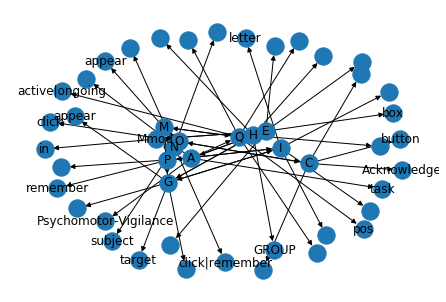

In [43]:
DRSToItem()